**CS-GY 9223: Deep Learning Final Project: Solving Natural Language Processing with Disaster Tweets on Kaggle with BERT**

by:

Yan Sun    <ys3928@nyu.edu>

Zhenming Wang <zw2365@nyu.edu>

**Section 1: Exploratory Data Analysis and Data Cleaning**

Reference:https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

# Step 0: Set Up Working Envoronment And Libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Deep Learning Final Project"                                    
%cd /content/gdrive/My Drive/Deep Learning Final Project

!pwd

/content/gdrive/My Drive/Deep Learning Final Project
/content/gdrive/My Drive/Deep Learning Final Project


In [3]:
!ls

 best_model_state.bin				 sample_submission.csv
'CS-GY 9223 Deep Learning Final Project.ipynb'	 test.csv
 EDA.ipynb					 train.csv


In [34]:
!python -m pip install wordcloud
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
import gensim

#from wordcloud import STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 1: Exploratory Data Analysis

## 1.1 Read data from files into pandas dataframe 

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')

In [7]:
# Output the size of each dataframe
df_train.shape, df_test.shape, df_sample_submission.shape

((7613, 5), (3263, 4), (3263, 2))

In [8]:
# Quick look at the content inside each dataframe
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
df_sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [22]:
# Merge df_sample_submission into df_test
df_test['target'] = df_sample_submission['target']
df_test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0


## 1.2 Class Distribution

First things fisrt, let us check the class distribution. There are only two classes 0 and 1.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Training Set Class Distribution')

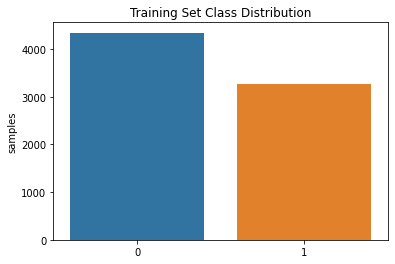

In [15]:
# Class distribution for training set
x = df_train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')
plt.title('Training Set Class Distribution')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test Set Class Distribution')

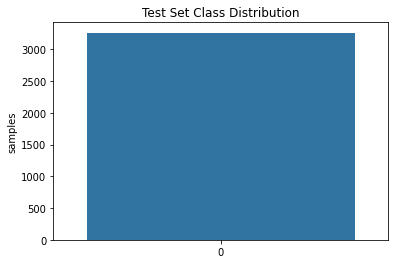

In [16]:
# Class distribution for test set
x = df_sample_submission.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')
plt.title('Test Set Class Distribution')

Observation: Target labels in training set are almost evenly distributed. In test set, there are only 0 labels, meaning that all texts in test.csv are non-disaster tweets.

## 1.3 Character & Word Count

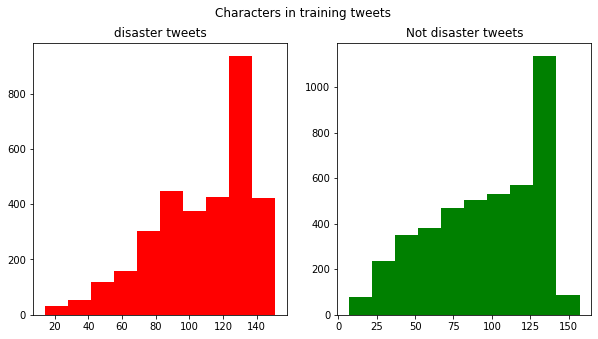

In [18]:
# Character count in training set
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = df_train[df_train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len = df_train[df_train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in training tweets')
plt.show()

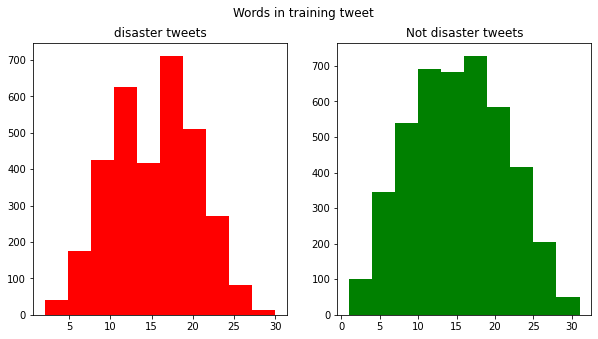

In [19]:
# Word count in training set
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in training tweet')
plt.show()

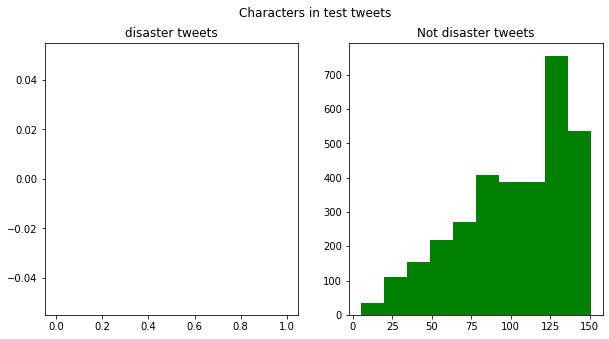

In [23]:
# Character count in test set
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = df_test[df_test['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len = df_test[df_test['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in test tweets')
plt.show()

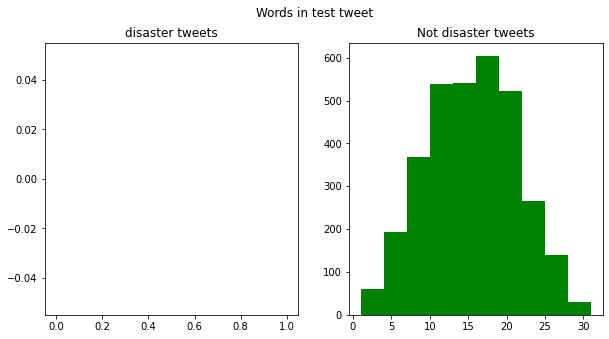

In [24]:
# Word count in test set
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = df_test[df_test['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=df_test[df_test['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in test tweet')
plt.show()

Observation: 

Tweets in both train and test set have about 120 to 140 characters and 20 to 30 words.

For training set, the distributions of both characters count and word counts are similar for disaster and non-disaster tweets.

## 1.4 Stopwords in Training Set

In [27]:
# helper function to create training corpus from text
def create_corpus(target):
    corpus=[]
    
    for x in df_train[df_train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

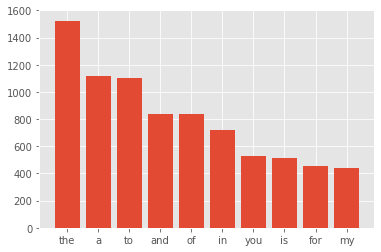

In [35]:
# First we analyze non-disaster tweets (class=0)
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

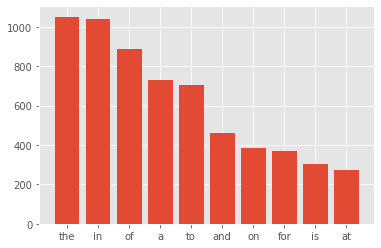

In [36]:
# Then we analyze disaster tweets (class=1)
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

Observation: 

1. Both disaster tweets and non-disaster tweets have the common stopwords 'the', 'a', 'in'.

2. Non-disaster tweets have more personal words such as 'you' and 'my' which show up less in disaster tweets.

## 1.5 Puctuations

<BarContainer object of 18 artists>

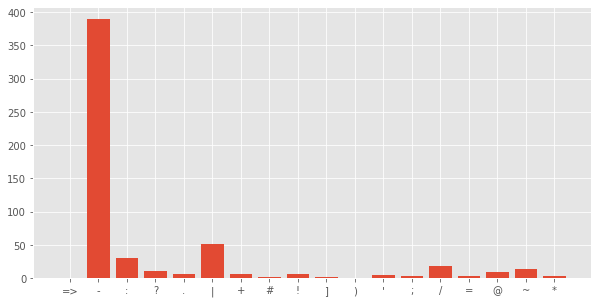

In [37]:
# Common puctuations in disaster tweets
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

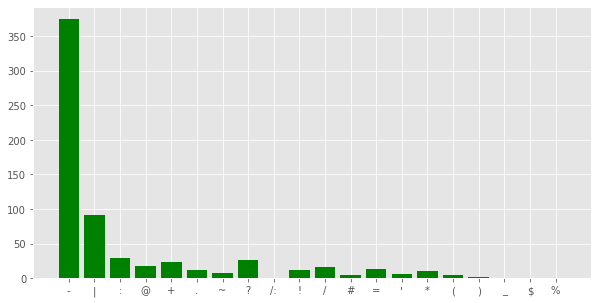

In [38]:
# Common puctuations in non-disaster tweets
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

Observation:

Both disaster and non-disaster tweets have similar distribution of puctuations.

## 1.6 Common Words

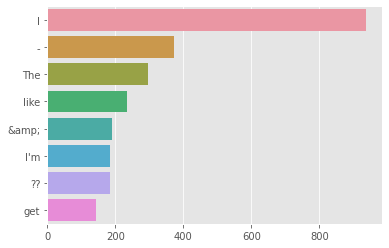

In [41]:
# Plot the most common words in training set
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

From the graphs above, puctuations and stopwords are most common in our training text, which means data cleaning is needed.

## 1.7 Ngram Analysis

We perform a bigram analysis over the tweets.
Let's check the most common bigrams in tweets.

In [42]:
# Helper function
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

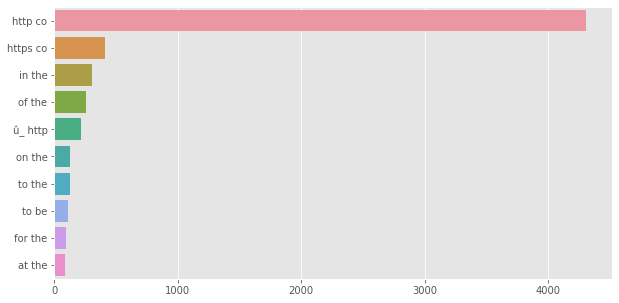

In [44]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(df_train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

Observation:

The most common bi-grams are those that do not give us any useful information. This also means that we need data cleaning.

# Step 2: Data Cleaning

For this project, we plan to do some basic cleaning such as spelling correction, removing punctuations, removing html tags and emojis.

## 2.1 Remove URL's

In [45]:
# Helper function to remove url from text
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [46]:
# Remove url's from text in both train and test set
df_train['text'] = df_train['text'].apply(lambda x : remove_URL(x))
df_test['text'] = df_test['text'].apply(lambda x : remove_URL(x))

In [48]:
# Have a look at the result text
df_test['text'].head()

0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dtype: object

## 2.2 Remove HTML Tags

In [50]:
# Helper function to remove html tags from text
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [51]:
# Remove html tags from text in both train and test set
df_train['text'] = df_train['text'].apply(lambda x : remove_html(x))
df_test['text'] = df_test['text'].apply(lambda x : remove_html(x))

In [52]:
df_test['text'].head()

0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dtype: object

## 2.3 Remove Emojis

In [53]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
# Helper function to remove emoji from text
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [54]:
# Remove emoji from text in both train and test set
df_train['text'] = df_train['text'].apply(lambda x : remove_emoji(x))
df_test['text'] = df_test['text'].apply(lambda x : remove_emoji(x))

## 2.4 Remove Punctuations

In [55]:
# Helper function to remove punctuations from text
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [56]:
# Remove puctuations from text in both train and test set
df_train['text'] = df_train['text'].apply(lambda x : remove_punct(x))
df_test['text'] = df_test['text'].apply(lambda x : remove_punct(x))

# Step 3: Check Cleaning Result

We check the reuslt of cleaning by performing again the bi-gram analysis.

In [57]:
# Helper function
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

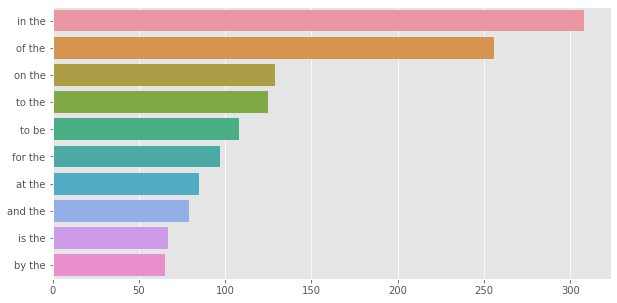

In [58]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(df_train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

Observation:

It is happy to see that puctuations and html tags no longer exists in the most common bigram tables.

Although in the picture above, the most common bi-gram after data cleaning are phrases made of stopwords, our BERT model in the next section will handle that easily.

# Step 4: Save the Result

In [59]:
# Write cleaned data into csv files for further use
df_train.to_csv('train_cleaned.csv')
df_test.to_csv('test_cleaned.csv')